# **8장. 성능 최적화**

# 8.1 성능 최적화

8.1.1 데이터를 사용한 최적화

    - 최대한 많은 데이터 수집하기
    - 데이터 생성하기 (이미지 조작)
    - 데이터 범위 조정하기 (scale)
    - 정규화, 규제화, 표준화 등

8.1.2 알고리즘을 이용한 성능 최적화

    - 알고리즘을 바꿔가면서 최적의 성능 보이는 알고리즘 선택

8.1.3 알고리즘 튜닝을 이용한 성능 최적화 (하이퍼파라미터)

    - 진단
    - 가중치
    - 학습률
    - 활성화 함수
    - 배치와 에포크
    - 옵티마이저 및 손실 함수
    - 네트워크 구성 (ex: 하나의 은닉층에 여러 뉴런(네트워크가 넓음), 여러 계층에 적은 뉴런(네트워크 깊음))

8.1.4 앙상블을 이용한 성능 최적화

    - 앙상블 : 모델을 두 개 이상 섞어서 사용하는 것

# 8.2 하드웨어를 이용한 성능 최적화 (CPU, GPU)

8.2.1 CPU와 GPU의 차이

    - CPU : 한 번에 하나의 명령어만 순차적으로 처리
    - GPU : 서로 다른 명령어를 동시에 병렬적으로 처리

# 8.3 하이퍼파라미터를 이용한 성능 최적화

1.  배치 정규화

  : 입력 분포 일정하게 만들어줌  ->  가중치가 올바르게 갱신되게 함
2.  드롭 아웃

  : 학습 중에 일부 뉴런을 무작위로 비활성화 -> 과적합 방지

3.  조기 종료

  : 훈련 - 검증 세트의 오차 비교하여, 검증 세트의 오차가 증가하는 시점에 멈춤

  + 학습률 감소 : 학습이 진행되는 과정에서 학습률을 조금씩 낮추어 주는 기법

    (주어진 'patience' 횟수만큼 검증세트의 오차 감소가 없을 시, 'factor'만큼 학습률 감소시킴)

In [6]:
#배치 정규화와 드롭아웃 예제

#라이브러리 호출
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

In [7]:
trainset = torchvision.datasets.FashionMNIST(root='/content/drive/MyDrive/pytorch_ex/chap08/data',
                                             train=True, download=True, transform=transforms.ToTensor())

In [8]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [17]:
#데이터셋 분리
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape) #torch.Size([4, 1, 28, 28]) : 가져올 배치 크기, 채널(흑백), 픽셀 크기(너비x높이)(28x28)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
4


**8.3.1 배치 정규화**

In [19]:
#이미지 몇 개만 출력
#전처리 함수

def imshow(img, title) :
  plt.figure(figsize=(batch_size * 4, 4)) #출력할 개별 이미지의 크기 지정
  plt.axis('off')
  plt.imshow(np.transpose(img, (1,2,0))) #기본적인 이미지 저장 순서(배치 크기, 채널, 너비, 높이) -> 맷플롯립(너비, 높이, 채널)
  plt.title(title)
  plt.show()

In [20]:
#이미지 데이터 출력 함수

def show_batch_images(dataloader) :
  images, labels = next(iter(dataloader)) #이미지 크기가 (4, 28, 28, 1)(배치크기, 채널, 너비, 높이)이 됨

  img = torchvision.utils.make_grid(images) #좌표와 이미지 픽셀 대응 -> 그리드 형태로 출력
  imshow(img, title=[str(x.item()) for x in labels]) #데이터 형태를 (채널, 너비, 높이) -> (높이, 너비, 채널) 변경

  return images, labels

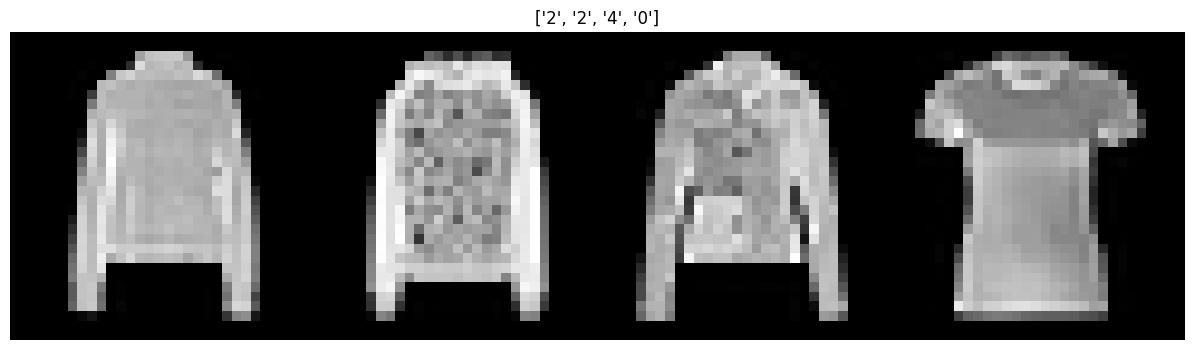

In [21]:
#이미지 출력
images, labels = show_batch_images(trainloader)

In [23]:
#배치 정규화 없는 네트워크

class NormalNet(nn.Module) :
  def __init__(self) :
    super(NormalNet, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784, 48), #(입력, 출력) : 784=28*28(일렬로 펼쳐서 입력)
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.ReLU(),
        nn.Linear(24, 10) #출력 클래스 10개
    )

  def forward(self, x) :
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [25]:
#배치 정규화 있는 네트워크

class BNNet(nn.Module) :
  def __init__(self) :
    super(BNNet, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784, 48),
        nn.BatchNorm1d(48), #배치 정규화 : 합성곱층과 완전연결층 뒤, 활성화함수 앞
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24, 10)
    )

  def forward(self, x) :
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [31]:
#모델 선언

#배치정규화 xx 모델
model = NormalNet()
print(model)

print('-'*20)

#배치정규화 oo 모델
model_bn = BNNet()
print(model_bn)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)
--------------------
BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [32]:
#데이터셋 메모리로 불러오기
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [33]:
#옵티마이저, 손실 함수

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

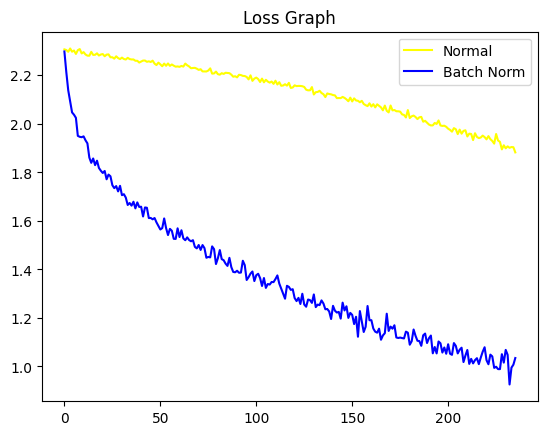

In [34]:
#모델 학습
loss_arr = []
loss_bn_arr = []
max_epochs = 2

for epoch in range(max_epochs) :
  for i, data in enumerate(trainloader, 0) :
    inputs, labels = data

    #배치정규화xx 모델 학습
    opt.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    #배치정규화oo 모델 학습
    opt_bn.zero_grad()
    outputs_bn = model_bn(inputs)
    loss_bn = loss_fn(outputs_bn, labels)
    loss_bn.backward()
    opt_bn.step()

    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())


plt.plot(loss_arr, 'yellow', label='Normal')
plt.plot(loss_bn_arr, 'blue', label='Batch Norm')
plt.legend()
plt.title('Loss Graph')
plt.show()

**8.3.2 드롭아웃**

In [35]:
#드롭아웃
#데이터셋 분포 출력하기 위한 전처리

N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
#torch.linspace(-1, 1, N) : -1 ~ 1의 범위에서 N개의 균등한 간격의 텐서 생성
#torch.unsqueeze((), 1) : 해당 텐서의 첫 번째 자리에 차원 추가
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
#torch.normal(평균, 표준편차) : 해당 정규분포로부터 무작위 표본 추출
#torch.zeros: 0을 원소로 하는 N x 1 텐서 생성   /   torch.ones : 1을 원소로 하는 N x 1 텐서 생성

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46021 (\N{HANGUL SYLLABLE DOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47549 (\N{HANGUL SYLLABLE RIB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

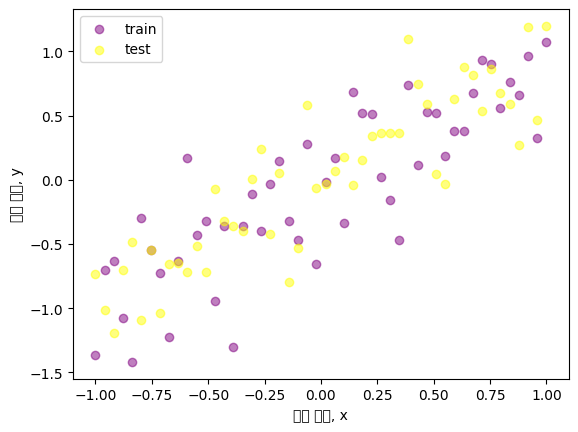

In [36]:
#데이터 분포를 그래프로 출력
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.xlabel('독립 변수, x')
plt.ylabel('종속 변수, y')
plt.legend()
plt.show()

In [37]:
#모델 생성
N_h = 100

#드롭아웃 적용 xx 모델
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1)
)

#드롭아웃 적용 oo 모델
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2), #드롭아웃 적용
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2), #드롭아웃 적용
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1)
)

In [38]:
#옵티마이저, 손실 함수
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

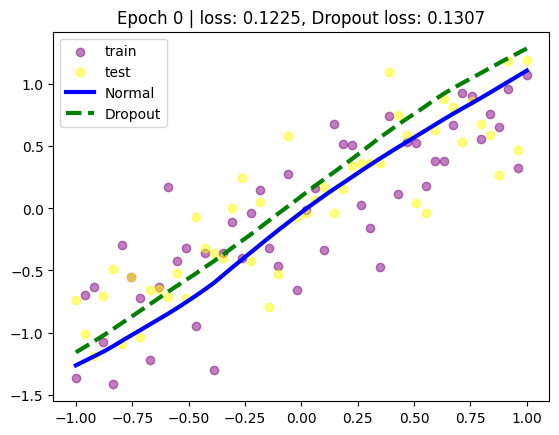

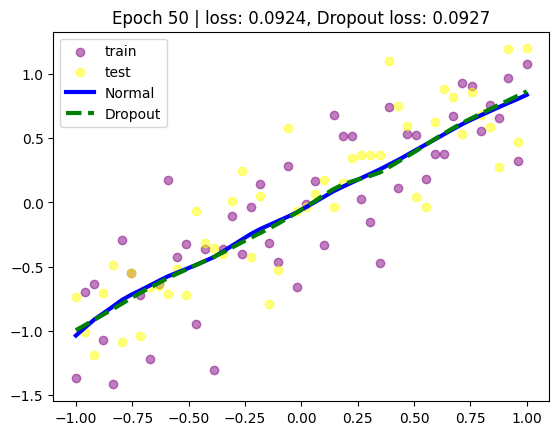

In [41]:
#모델 학습
max_epochs = 100
for epoch in range(max_epochs) :
  #드롭아웃 xx 모델
  pred = model(x_train)
  loss = loss_fn(pred, y_train)
  opt.zero_grad()
  loss.backward()
  opt.step()

  #드롭아웃 oo 모델
  pred_dropout = model_dropout(x_train)
  loss_dropout = loss_fn(pred_dropout, y_train)
  opt_dropout.zero_grad()
  loss_dropout.backward()
  opt_dropout.step()

  if epoch % 50 == 0 :
    model.eval()
    ######
    model_dropout.eval()

    test_pred = model(x_test)
    test_loss = loss_fn(test_pred, y_test)
    ######
    test_pred_dropout = model_dropout(x_test)
    test_loss_dropout = loss_fn(test_pred_dropout, y_test)

    plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
    plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')

    plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='Normal')
    ######
    plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3, label='Dropout')

    plt.title(f'Epoch {epoch} | loss: {test_loss:.4f}, Dropout loss: {test_loss_dropout:.4f}')
    plt.legend()
    model.train()
    model_dropout.train()
    plt.pause(0.05)

**8.3.3 조기 종료**

In [1]:
#라이브러리 호출

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models #사전 학습된 모델 이용
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm

matplotlib.style.use('ggplot') #출력 그래프에서 격자 사용 -> 숫자 범위 눈에 잘 띄게 하는 스타일
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )

In [13]:
#데이터셋 전처리
train_transform = transforms.Compose([
    transforms.Resize( (224, 224) ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize( (224, 224) ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
#데이터셋 가져오기(핫도그인지, 아닌지)

train_dataset = datasets.ImageFolder(
    root=r'/content/drive/MyDrive/pytorch_ex/chap08/data/archive/train',
    transform=train_transform
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

val_dataset = datasets.ImageFolder(
    root=r'/content/drive/MyDrive/pytorch_ex/chap08/data/archive/test',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False
)

In [15]:
#모델 생성(기존에 학습된 모델 사용)

def resnet50(pretrained=True, requires_grad=False) :
  model = models.resnet50(progress=True, pretrained=pretrained)
  if requires_grad == False :
    for param in model.parameters() :
      param.requires_grad = False
  elif requires_grad == True :
    for param in model.parameters() :
      param.requires_grad = True
  model.fc = nn.Linear(2048, 2)
  return model

In [16]:
#학습률 감소 클래스

class LRScheduler() :
  def __init__( self, optimizer, patience=5, min_lr=1e-6, factor=0.5 ) :
    self.optimizer = optimizer
    self.patience = patience
    self.min_lr = min_lr
    self.factor = factor
    self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( #검증세트 오차에 변화 없을 시 학습률을 factor배 감소시킴 (콜백 함수)
        self.optimizer, #파라미터 갱신(Adam)
        mode='min', #학습률 조정의 기준(오차)이 '최소'일 때 조정 (조정 기준이 정확도일 땐, '최대'일 때 조정)
        patience=self.patience, #학습률 업데이트 이전 patience에포크만큼 기다림
        factor=self.factor, #새 학습률 = 학습률 * factor
        min_lr=self.min_lr, #학습률의 하한선
        verbose=True #조기종료의 시작과 끝 출력
    )

In [17]:
#조기 종려 클래스

class EarlyStopping() :
  def __init__(self, patience=5, verbose=False, delta=0,
               path='/content/drive/MyDrive/pytorch_ex/chap08/data/checkpoint.pt') :
    self.patience = patience
    self.verbose = verbose
    self.counter = 0 #오차가 멈춘 횟수 저장
    self.best_score = None #검증 세트의 오차 가장 작은 값(최적화 값)
    self.early_stop = False #조기종료 초깃값 False
    self.val_loss_min = np.inf #무한대
    self.delta = delta #오차가 delta보다 적으면 개선x 판단
    self.path = path #모델이 저장된 경로

  def __call__(self, val_loss, model) :
    score = -val_loss
    if self.best_score is None : #처음
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta : #오차가 delta보다 적어서, 개선 안될 때
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience : #patience 횟수만큼 개선 안 될 때 -> 조기종료
        self.early_stop = True
    else :
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model) :
    if self.verbose :
      print(f'Validation loss decreased ({self.val_loss_min:.6f}), Saving Model ...')
      torch.save(model.state_dict(), self.path)
      self.val_loss_min = val_loss

In [22]:
#인수 값 지정
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
#.add_argument(명령어, 변수 이름, =True로 저장) : '변수 이름'에 '명령어'='True'로 저장하여 추가
args = vars(parser.parse_args(args=[]))

In [21]:
pip install ipywidgets

In [23]:
#사전 훈련된 모델의 파라미터 확인
print(f'Computation device: {device}\n') #CPU인지 GPU인지 확인

model = models.resnet50(pretrained=True).to(device) #사전훈련된 ResNet50 사용
total_params = sum( p.numel() for p in model.parameters() )
print(f'{total_params:,} total parameters') #총 파라미터 수

total_trainable_params = sum( p.numel() for p in model.parameters() if p.requires_grad )
print(f'{total_trainable_params:,} training parameters') #훈련 가능한 파라미터 수

Computation device: cuda:0



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.1MB/s]


25,557,032 total parameters
25,557,032 training parameters


In [24]:
#옵티마이저와 손실 함수 지정
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [26]:
#(1) '--lr-scheduler', '--early-stopping' 인수 사용 않을 때
#오차, 정확도, 모델 이름에 대한 문자열 지정

loss_plot_name = 'loss' #(학습률 감소, 조기종료 적용 안할 때 사용할) 오차 출력 문자열
acc_plot_name = 'accuracy' #(학습률 감소, 조기종료 적용 안할 때 사용할) 정확도 출력 문자열
model_name = 'model' #(학습률 감소, 조기종료 적용 안할 때 사용할) 모델 저장할 문자열

In [31]:
#(2) '--lr-scheduler', '--early-stopping' 인수 사용할 때
#오차, 정확도, 모델 이름에 대한 문자열 지정

if args['lr_scheduler'] :
  print('INFO: Initializing learning rate scheduler')
  lr_scheduler = LRScheduler(optimizer)
  loss_plot_name = 'lrs_loss' #(학습률 감소를 적용했을 때 사용할) 오차 문자열
  acc_plot_name = 'lrs_accuracy' #(학습률 감소를 적용했을 때 사용할) 정확도 문자열
  model_name = 'lrs_model' #(학습률 감소를 적용했을 때 사용할) 모델 문자열

if args['early_stopping'] :
  print('INFO: Initializing early stopping')
  early_stopping = EarlyStopping()
  loss_plot_name = 'es_loss' #(조기 종료를 적용했을 때 사용할) 오차 문자열
  acc_plot_name = 'es_accuracy' #(조기 종료를 적용했을 때 사용할) 정확도 문자열
  model_name = 'es_model' #(조기 종료를 적용했을 때 사용할) 모델 문자열

In [29]:
#모델 학습 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion) :
  print('Training')
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0.0
  counter = 0
  total = 0
  prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))

  for i, data in prog_bar :
    counter += 1
    data, target = data[0].to(device), data[1].to(device)
    total += target.size(0)
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    train_running_loss += loss.item()
    _, preds = torch.max(outputs.data, 1)
    train_running_correct += (preds == target).sum().item()
    loss.backward()
    optimizer.step()

  train_loss = train_running_loss / counter
  train_accuracy = 100. * train_running_correct / total
  return train_loss, train_accuracy

In [30]:
from functools import total_ordering
#모델 성능 검증 함수
def validate(model, test_dataloader, val_dataset, criterion) :
  print('Validating')
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0
  counter = 0
  total = 0
  prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
  with torch.no_grad() :
    for i, data in prog_bar :
      counter += 1
      data, target = data[0].to(device), data[1].to(device)
      total += target.size(0)
      outputs = model(data)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      _, preds = torch.max(outputs.data, 1)
      val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss / counter
    val_accuracy = 100. * val_running_correct / total
    return val_loss, val_accuracy

In [33]:
from re import L
#모델 학습

train_loss, train_accuracy = [], [] #훈련 세트를 이용한 모델 학습 결과(오차, 정확도) 저장하기 위한 리스트
val_loss, val_accuracy = [], [] #검증 세트를 이용한 모델 학습 결과(오차, 정확도) 저장하기 위한 리스트

start = time.time()
for epoch in range(epochs) :
  print(f'Epoch {epoch+1} of {epochs}')
  train_epoch_loss, train_epoch_accuracy = training( model, train_dataloader, train_dataset, optimizer, criterion )
  val_epoch_loss, val_epoch_accuracy = validate( model, val_dataloader, val_dataset, criterion )
  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)
  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)
  if args['lr_scheduler'] :
    lr_scheduler(val_epoch_loss)
  if args['early_stopping'] :
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop :
      break
  print(f'Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}')
  print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')

end = time.time()
print(f'Training time: {(end-start)/60:.3f} minutes')

Epoch 1 of 100
Training


16it [03:25, 12.85s/it]


Validating


16it [03:22, 12.67s/it]


Train Loss: 2.1416, Train Acc: 58.63
Val Loss: 53.4686, Val Acc: 37.60
Epoch 2 of 100
Training


16it [00:05,  2.78it/s]


Validating


16it [00:04,  3.46it/s]


Train Loss: 0.6122, Train Acc: 70.08
Val Loss: 0.8273, Val Acc: 55.80
Epoch 3 of 100
Training


16it [00:05,  2.79it/s]


Validating


16it [00:04,  3.24it/s]


Train Loss: 0.4802, Train Acc: 78.11
Val Loss: 0.7796, Val Acc: 70.40
Epoch 4 of 100
Training


16it [00:07,  2.10it/s]


Validating


16it [00:05,  3.07it/s]


Train Loss: 0.3877, Train Acc: 81.93
Val Loss: 0.7642, Val Acc: 71.20
Epoch 5 of 100
Training


16it [00:06,  2.39it/s]


Validating


16it [00:05,  2.85it/s]


Train Loss: 0.4728, Train Acc: 78.31
Val Loss: 1.8045, Val Acc: 62.40
Epoch 6 of 100
Training


16it [00:05,  2.68it/s]


Validating


16it [00:05,  2.83it/s]


Train Loss: 0.3597, Train Acc: 84.54
Val Loss: 0.5938, Val Acc: 77.40
Epoch 7 of 100
Training


16it [00:05,  2.81it/s]


Validating


16it [00:06,  2.50it/s]


Train Loss: 0.2795, Train Acc: 87.35
Val Loss: 0.8464, Val Acc: 70.60
Epoch 8 of 100
Training


16it [00:06,  2.51it/s]


Validating


16it [00:07,  2.17it/s]


Train Loss: 0.2619, Train Acc: 89.56
Val Loss: 0.5028, Val Acc: 75.60
Epoch 9 of 100
Training


16it [00:06,  2.57it/s]


Validating


16it [00:06,  2.53it/s]


Train Loss: 0.2907, Train Acc: 88.35
Val Loss: 0.5965, Val Acc: 74.00
Epoch 10 of 100
Training


16it [00:05,  2.97it/s]


Validating


16it [00:04,  3.27it/s]


Train Loss: 0.1858, Train Acc: 93.37
Val Loss: 0.5476, Val Acc: 81.40
Epoch 11 of 100
Training


16it [00:06,  2.61it/s]


Validating


16it [00:05,  2.88it/s]


Train Loss: 0.2150, Train Acc: 90.36
Val Loss: 0.8263, Val Acc: 76.00
Epoch 12 of 100
Training


16it [00:06,  2.66it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.2383, Train Acc: 89.96
Val Loss: 1.2193, Val Acc: 69.00
Epoch 13 of 100
Training


16it [00:05,  2.92it/s]


Validating


16it [00:04,  3.28it/s]


Train Loss: 0.2754, Train Acc: 88.96
Val Loss: 1.0441, Val Acc: 69.80
Epoch 14 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:05,  3.02it/s]


Train Loss: 0.2714, Train Acc: 89.16
Val Loss: 1.0899, Val Acc: 72.80
Epoch 15 of 100
Training


16it [00:05,  3.10it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.2122, Train Acc: 89.76
Val Loss: 0.7359, Val Acc: 75.00
Epoch 16 of 100
Training


16it [00:05,  2.85it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.2234, Train Acc: 91.37
Val Loss: 0.8682, Val Acc: 77.40
Epoch 17 of 100
Training


16it [00:05,  2.76it/s]


Validating


16it [00:04,  3.41it/s]


Train Loss: 0.1442, Train Acc: 94.18
Val Loss: 0.7329, Val Acc: 74.20
Epoch 18 of 100
Training


16it [00:05,  3.09it/s]


Validating


16it [00:05,  3.10it/s]


Train Loss: 0.1154, Train Acc: 95.38
Val Loss: 0.8197, Val Acc: 77.40
Epoch 19 of 100
Training


16it [00:05,  3.11it/s]


Validating


16it [00:05,  3.16it/s]


Train Loss: 0.1142, Train Acc: 95.58
Val Loss: 0.7433, Val Acc: 76.80
Epoch 20 of 100
Training


16it [00:05,  3.02it/s]


Validating


16it [00:04,  3.44it/s]


Train Loss: 0.0749, Train Acc: 97.19
Val Loss: 0.8576, Val Acc: 79.40
Epoch 21 of 100
Training


16it [00:05,  2.78it/s]


Validating


16it [00:05,  3.11it/s]


Train Loss: 0.0941, Train Acc: 96.39
Val Loss: 1.2677, Val Acc: 74.40
Epoch 22 of 100
Training


16it [00:06,  2.47it/s]


Validating


16it [00:04,  3.43it/s]


Train Loss: 0.2289, Train Acc: 92.17
Val Loss: 1.0793, Val Acc: 77.00
Epoch 23 of 100
Training


16it [00:05,  3.08it/s]


Validating


16it [00:05,  3.09it/s]


Train Loss: 0.2479, Train Acc: 89.56
Val Loss: 0.8653, Val Acc: 72.80
Epoch 24 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:04,  3.32it/s]


Train Loss: 0.2303, Train Acc: 91.37
Val Loss: 0.6828, Val Acc: 75.20
Epoch 25 of 100
Training


16it [00:05,  2.92it/s]


Validating


16it [00:04,  3.50it/s]


Train Loss: 0.2927, Train Acc: 88.35
Val Loss: 0.9702, Val Acc: 69.00
Epoch 26 of 100
Training


16it [00:06,  2.54it/s]


Validating


16it [00:04,  3.21it/s]


Train Loss: 0.1849, Train Acc: 92.97
Val Loss: 0.7111, Val Acc: 73.20
Epoch 27 of 100
Training


16it [00:05,  3.10it/s]


Validating


16it [00:05,  3.15it/s]


Train Loss: 0.0940, Train Acc: 96.99
Val Loss: 0.8086, Val Acc: 77.00
Epoch 28 of 100
Training


16it [00:05,  3.10it/s]


Validating


16it [00:05,  3.13it/s]


Train Loss: 0.0702, Train Acc: 98.39
Val Loss: 1.1930, Val Acc: 71.40
Epoch 29 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:04,  3.45it/s]


Train Loss: 0.0858, Train Acc: 96.79
Val Loss: 0.8017, Val Acc: 77.80
Epoch 30 of 100
Training


16it [00:05,  2.78it/s]


Validating


16it [00:04,  3.44it/s]


Train Loss: 0.0546, Train Acc: 98.19
Val Loss: 0.6097, Val Acc: 80.20
Epoch 31 of 100
Training


16it [00:05,  2.96it/s]


Validating


16it [00:04,  3.29it/s]


Train Loss: 0.0860, Train Acc: 96.59
Val Loss: 1.0346, Val Acc: 77.20
Epoch 32 of 100
Training


16it [00:05,  3.10it/s]


Validating


16it [00:05,  3.05it/s]


Train Loss: 0.0921, Train Acc: 97.39
Val Loss: 0.8017, Val Acc: 79.00
Epoch 33 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:04,  3.43it/s]


Train Loss: 0.0740, Train Acc: 98.39
Val Loss: 0.7579, Val Acc: 76.00
Epoch 34 of 100
Training


16it [00:05,  2.84it/s]


Validating


16it [00:04,  3.44it/s]


Train Loss: 0.1811, Train Acc: 93.98
Val Loss: 1.0750, Val Acc: 72.20
Epoch 35 of 100
Training


16it [00:05,  2.77it/s]


Validating


16it [00:04,  3.45it/s]


Train Loss: 0.1735, Train Acc: 93.78
Val Loss: 0.8356, Val Acc: 73.60
Epoch 36 of 100
Training


16it [00:05,  3.10it/s]


Validating


16it [00:05,  3.06it/s]


Train Loss: 0.0993, Train Acc: 95.18
Val Loss: 0.9672, Val Acc: 75.80
Epoch 37 of 100
Training


16it [00:05,  3.11it/s]


Validating


16it [00:04,  3.26it/s]


Train Loss: 0.1523, Train Acc: 94.98
Val Loss: 2.1891, Val Acc: 63.80
Epoch 38 of 100
Training


16it [00:05,  3.00it/s]


Validating


16it [00:04,  3.46it/s]


Train Loss: 0.0999, Train Acc: 96.39
Val Loss: 0.7817, Val Acc: 75.40
Epoch 39 of 100
Training


16it [00:05,  2.80it/s]


Validating


16it [00:04,  3.49it/s]


Train Loss: 0.0831, Train Acc: 97.19
Val Loss: 1.3960, Val Acc: 73.60
Epoch 40 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:04,  3.22it/s]


Train Loss: 0.0501, Train Acc: 98.19
Val Loss: 1.1117, Val Acc: 72.60
Epoch 41 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:05,  3.09it/s]


Train Loss: 0.0671, Train Acc: 97.99
Val Loss: 0.8991, Val Acc: 75.00
Epoch 42 of 100
Training


16it [00:05,  3.10it/s]


Validating


16it [00:04,  3.51it/s]


Train Loss: 0.0643, Train Acc: 97.99
Val Loss: 0.6449, Val Acc: 81.20
Epoch 43 of 100
Training


16it [00:05,  2.82it/s]


Validating


16it [00:04,  3.50it/s]


Train Loss: 0.0587, Train Acc: 97.79
Val Loss: 0.7966, Val Acc: 78.00
Epoch 44 of 100
Training


16it [00:05,  2.96it/s]


Validating


16it [00:04,  3.33it/s]


Train Loss: 0.0684, Train Acc: 97.79
Val Loss: 0.8477, Val Acc: 80.20
Epoch 45 of 100
Training


16it [00:05,  3.11it/s]


Validating


16it [00:05,  3.06it/s]


Train Loss: 0.0498, Train Acc: 98.39
Val Loss: 0.9567, Val Acc: 80.40
Epoch 46 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:04,  3.42it/s]


Train Loss: 0.0783, Train Acc: 97.39
Val Loss: 0.8876, Val Acc: 76.40
Epoch 47 of 100
Training


16it [00:05,  2.76it/s]


Validating


16it [00:04,  3.45it/s]


Train Loss: 0.0812, Train Acc: 96.99
Val Loss: 1.0572, Val Acc: 76.80
Epoch 48 of 100
Training


16it [00:05,  2.81it/s]


Validating


16it [00:04,  3.48it/s]


Train Loss: 0.1122, Train Acc: 95.98
Val Loss: 1.5878, Val Acc: 69.80
Epoch 49 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:05,  3.10it/s]


Train Loss: 0.1262, Train Acc: 95.98
Val Loss: 0.8160, Val Acc: 75.80
Epoch 50 of 100
Training


16it [00:05,  3.11it/s]


Validating


16it [00:04,  3.27it/s]


Train Loss: 0.0973, Train Acc: 96.59
Val Loss: 0.7577, Val Acc: 78.00
Epoch 51 of 100
Training


16it [00:05,  2.98it/s]


Validating


16it [00:04,  3.52it/s]


Train Loss: 0.0697, Train Acc: 96.99
Val Loss: 1.2376, Val Acc: 76.60
Epoch 52 of 100
Training


16it [00:05,  2.82it/s]


Validating


16it [00:04,  3.48it/s]


Train Loss: 0.0780, Train Acc: 96.59
Val Loss: 0.9501, Val Acc: 77.60
Epoch 53 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:05,  2.88it/s]


Train Loss: 0.0750, Train Acc: 97.39
Val Loss: 1.0213, Val Acc: 75.80
Epoch 54 of 100
Training


16it [00:05,  3.10it/s]


Validating


16it [00:05,  3.07it/s]


Train Loss: 0.0816, Train Acc: 97.99
Val Loss: 1.0262, Val Acc: 77.20
Epoch 55 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:04,  3.47it/s]


Train Loss: 0.0850, Train Acc: 96.99
Val Loss: 1.0456, Val Acc: 76.80
Epoch 56 of 100
Training


16it [00:05,  2.79it/s]


Validating


16it [00:04,  3.49it/s]


Train Loss: 0.0958, Train Acc: 96.18
Val Loss: 1.0613, Val Acc: 76.40
Epoch 57 of 100
Training


16it [00:05,  2.90it/s]


Validating


16it [00:04,  3.41it/s]


Train Loss: 0.0605, Train Acc: 97.79
Val Loss: 1.0785, Val Acc: 74.00
Epoch 58 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:05,  3.07it/s]


Train Loss: 0.0625, Train Acc: 97.39
Val Loss: 0.7368, Val Acc: 79.40
Epoch 59 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:04,  3.41it/s]


Train Loss: 0.0379, Train Acc: 99.00
Val Loss: 0.8501, Val Acc: 76.40
Epoch 60 of 100
Training


16it [00:05,  2.90it/s]


Validating


16it [00:04,  3.50it/s]


Train Loss: 0.0484, Train Acc: 98.59
Val Loss: 0.9404, Val Acc: 76.40
Epoch 61 of 100
Training


16it [00:05,  2.79it/s]


Validating


16it [00:04,  3.50it/s]


Train Loss: 0.0753, Train Acc: 97.59
Val Loss: 1.0835, Val Acc: 73.80
Epoch 62 of 100
Training


16it [00:05,  3.09it/s]


Validating


16it [00:05,  3.12it/s]


Train Loss: 0.0713, Train Acc: 97.39
Val Loss: 1.1578, Val Acc: 73.40
Epoch 63 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:04,  3.26it/s]


Train Loss: 0.1036, Train Acc: 97.39
Val Loss: 1.0097, Val Acc: 77.00
Epoch 64 of 100
Training


16it [00:05,  3.02it/s]


Validating


16it [00:04,  3.48it/s]


Train Loss: 0.0591, Train Acc: 98.19
Val Loss: 1.0984, Val Acc: 74.20
Epoch 65 of 100
Training


16it [00:05,  2.80it/s]


Validating


16it [00:04,  3.46it/s]


Train Loss: 0.0532, Train Acc: 98.19
Val Loss: 0.6543, Val Acc: 78.80
Epoch 66 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:04,  3.26it/s]


Train Loss: 0.0456, Train Acc: 99.00
Val Loss: 0.7559, Val Acc: 75.80
Epoch 67 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:05,  3.12it/s]


Train Loss: 0.0642, Train Acc: 98.19
Val Loss: 1.0605, Val Acc: 74.40
Epoch 68 of 100
Training


16it [00:05,  3.12it/s]


Validating


16it [00:04,  3.49it/s]


Train Loss: 0.0437, Train Acc: 98.39
Val Loss: 0.8392, Val Acc: 77.60
Epoch 69 of 100
Training


16it [00:05,  2.80it/s]


Validating


16it [00:04,  3.48it/s]


Train Loss: 0.0826, Train Acc: 97.79
Val Loss: 1.4809, Val Acc: 75.20
Epoch 70 of 100
Training


16it [00:05,  2.96it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.1229, Train Acc: 96.39
Val Loss: 1.1842, Val Acc: 70.80
Epoch 71 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:05,  3.10it/s]


Train Loss: 0.0928, Train Acc: 97.19
Val Loss: 0.9269, Val Acc: 76.40
Epoch 72 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:04,  3.40it/s]


Train Loss: 0.0892, Train Acc: 97.39
Val Loss: 1.0206, Val Acc: 72.20
Epoch 73 of 100
Training


16it [00:05,  2.87it/s]


Validating


16it [00:04,  3.49it/s]


Train Loss: 0.0723, Train Acc: 96.99
Val Loss: 0.9498, Val Acc: 76.60
Epoch 74 of 100
Training


16it [00:05,  2.86it/s]


Validating


16it [00:04,  3.55it/s]


Train Loss: 0.0630, Train Acc: 97.79
Val Loss: 1.2134, Val Acc: 72.00
Epoch 75 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.0585, Train Acc: 97.39
Val Loss: 1.8102, Val Acc: 69.00
Epoch 76 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:04,  3.29it/s]


Train Loss: 0.0840, Train Acc: 96.99
Val Loss: 1.3308, Val Acc: 75.40
Epoch 77 of 100
Training


16it [00:05,  2.96it/s]


Validating


16it [00:04,  3.47it/s]


Train Loss: 0.0432, Train Acc: 98.39
Val Loss: 1.4052, Val Acc: 71.20
Epoch 78 of 100
Training


16it [00:05,  2.80it/s]


Validating


16it [00:04,  3.47it/s]


Train Loss: 0.0458, Train Acc: 97.99
Val Loss: 0.8983, Val Acc: 75.80
Epoch 79 of 100
Training


16it [00:05,  3.05it/s]


Validating


16it [00:04,  3.21it/s]


Train Loss: 0.0380, Train Acc: 99.00
Val Loss: 1.3545, Val Acc: 71.80
Epoch 80 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:05,  3.11it/s]


Train Loss: 0.0378, Train Acc: 98.59
Val Loss: 0.8700, Val Acc: 79.20
Epoch 81 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:04,  3.21it/s]


Train Loss: 0.0406, Train Acc: 98.39
Val Loss: 0.8716, Val Acc: 79.20
Epoch 82 of 100
Training


16it [00:05,  2.68it/s]


Validating


16it [00:04,  3.42it/s]


Train Loss: 0.0166, Train Acc: 99.80
Val Loss: 0.8318, Val Acc: 78.40
Epoch 83 of 100
Training


16it [00:05,  2.97it/s]


Validating


16it [00:04,  3.38it/s]


Train Loss: 0.0293, Train Acc: 99.00
Val Loss: 0.8568, Val Acc: 76.40
Epoch 84 of 100
Training


16it [00:05,  3.14it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.0222, Train Acc: 98.80
Val Loss: 1.2122, Val Acc: 77.00
Epoch 85 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.0191, Train Acc: 99.40
Val Loss: 0.9150, Val Acc: 77.40
Epoch 86 of 100
Training


16it [00:05,  2.87it/s]


Validating


16it [00:04,  3.51it/s]


Train Loss: 0.0064, Train Acc: 100.00
Val Loss: 1.0027, Val Acc: 78.20
Epoch 87 of 100
Training


16it [00:05,  2.85it/s]


Validating


16it [00:04,  3.55it/s]


Train Loss: 0.0129, Train Acc: 99.40
Val Loss: 0.8458, Val Acc: 81.80
Epoch 88 of 100
Training


16it [00:05,  3.16it/s]


Validating


16it [00:05,  3.14it/s]


Train Loss: 0.0024, Train Acc: 100.00
Val Loss: 0.8108, Val Acc: 81.20
Epoch 89 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:04,  3.23it/s]


Train Loss: 0.0061, Train Acc: 99.80
Val Loss: 0.7734, Val Acc: 80.80
Epoch 90 of 100
Training


16it [00:05,  3.01it/s]


Validating


16it [00:04,  3.52it/s]


Train Loss: 0.0078, Train Acc: 99.80
Val Loss: 0.9327, Val Acc: 79.40
Epoch 91 of 100
Training


16it [00:05,  2.84it/s]


Validating


16it [00:04,  3.47it/s]


Train Loss: 0.0345, Train Acc: 98.59
Val Loss: 0.9652, Val Acc: 78.80
Epoch 92 of 100
Training


16it [00:05,  3.04it/s]


Validating


16it [00:05,  3.19it/s]


Train Loss: 0.0509, Train Acc: 98.39
Val Loss: 1.5008, Val Acc: 74.20
Epoch 93 of 100
Training


16it [00:05,  3.15it/s]


Validating


16it [00:05,  3.12it/s]


Train Loss: 0.0785, Train Acc: 96.99
Val Loss: 1.8654, Val Acc: 74.40
Epoch 94 of 100
Training


16it [00:05,  3.13it/s]


Validating


16it [00:04,  3.43it/s]


Train Loss: 0.1085, Train Acc: 96.99
Val Loss: 1.2728, Val Acc: 74.00
Epoch 95 of 100
Training


16it [00:05,  2.81it/s]


Validating


16it [00:04,  3.46it/s]


Train Loss: 0.0722, Train Acc: 97.19
Val Loss: 1.4106, Val Acc: 74.60
Epoch 96 of 100
Training


16it [00:05,  2.86it/s]


Validating


16it [00:04,  3.39it/s]


Train Loss: 0.0520, Train Acc: 97.99
Val Loss: 1.2415, Val Acc: 72.00
Epoch 97 of 100
Training


16it [00:05,  3.12it/s]


Validating


16it [00:05,  3.07it/s]


Train Loss: 0.0388, Train Acc: 98.59
Val Loss: 1.2250, Val Acc: 72.00
Epoch 98 of 100
Training


16it [00:05,  3.12it/s]


Validating


16it [00:04,  3.28it/s]


Train Loss: 0.0414, Train Acc: 97.79
Val Loss: 0.9663, Val Acc: 78.80
Epoch 99 of 100
Training


16it [00:05,  2.96it/s]


Validating


16it [00:04,  3.46it/s]


Train Loss: 0.0364, Train Acc: 99.20
Val Loss: 1.1619, Val Acc: 75.00
Epoch 100 of 100
Training


16it [00:05,  2.81it/s]


Validating


16it [00:04,  3.48it/s]

Train Loss: 0.0484, Train Acc: 98.39
Val Loss: 0.9172, Val Acc: 76.20
Training time: 23.933 minutes


Saving loss and accuracy plots...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/pytorch_ex/chap08/img/accuracy.png'

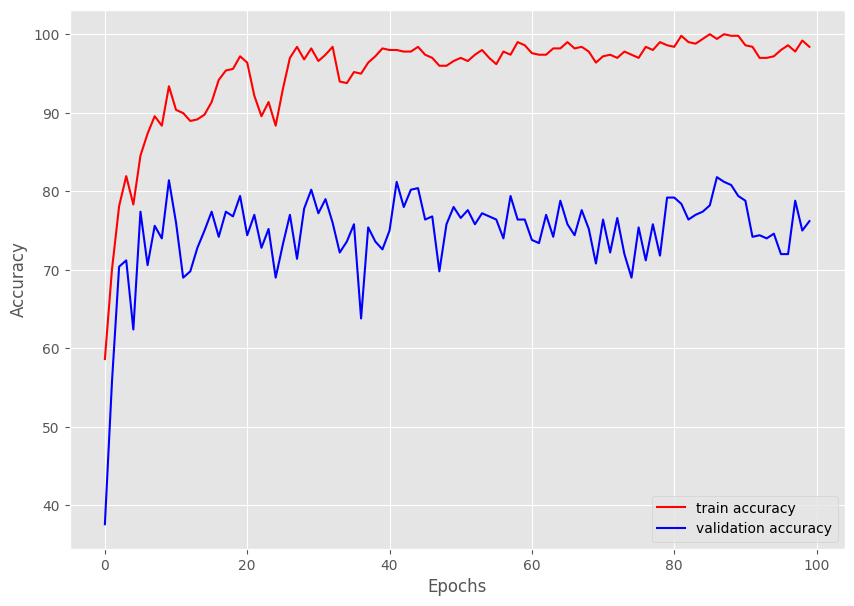

In [34]:
#모델 학습 결과 출력
print('Saving loss and accuracy plots...')

#정확도 비교 그래프
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='red', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'/content/drive/MyDrive/pytorch_ex/chap08/img/{acc_plot_name}.png')
plt.show()

#오차 비교 그래프
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='green', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'/content/drive/MyDrive/pytorch_ex/chap08/img/{loss_plot_name}.png')
plt.show()

print('Saving model...')
torch.save(model.state_dict(), f'/content/drive/MyDrive/pytorch_ex/chap08/img/{model_name}.pth')
print('TRAINING COMPLETE')